SINE-GORDON SIMULATIONS

Sine-Gordon simulations completed!

THIRRING MODEL SIMULATIONS
Thirring model simulations completed!


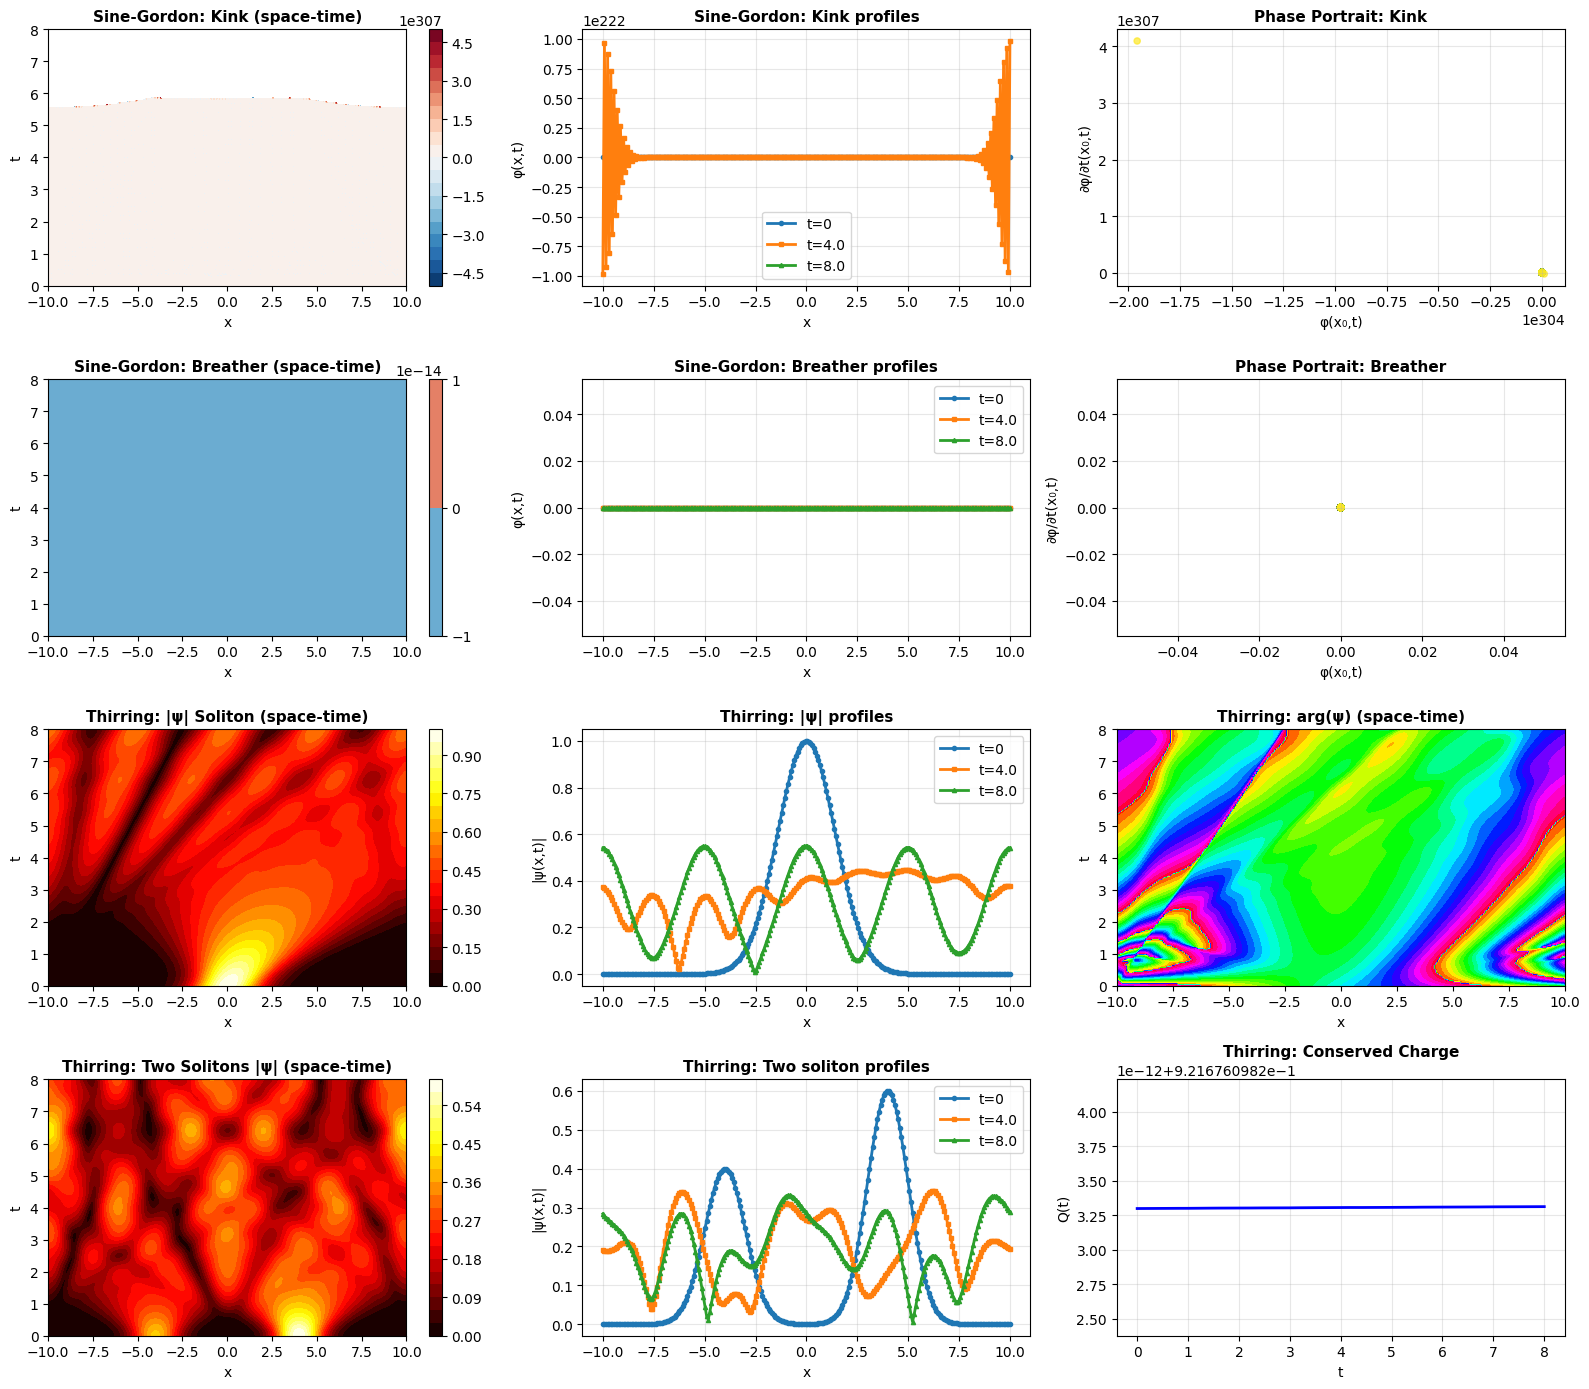


SUMMARY
Sine-Gordon Kink: Initial amplitude = 6.2830
Sine-Gordon Breather: Max amplitude = 0.0000
Thirring Soliton: Initial charge = 0.9217
Thirring: Charge conservation error = 1.38e-14

Plots saved as 'sine_gordon_thirring_analysis.png'


In [2]:
# Sine-Gordon and Thirring Model Simulation
# Comprehensive notebook combining both models with visualization

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp
from scipy.fft import fft, ifft, fftfreq
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# 1. SINE-GORDON EQUATION SOLVER (1+1D)
# ============================================================================

class SineGordonSolver:
    """Solves the sine-Gordon equation: φ_tt - φ_xx + sin(φ) = 0"""
    
    def __init__(self, L=20, nx=200, T=10, nt=200):
        self.L = L  # spatial domain [-L/2, L/2]
        self.nx = nx
        self.T = T
        self.nt = nt
        
        self.x = np.linspace(-L/2, L/2, nx)
        self.t = np.linspace(0, T, nt)
        self.dx = L / (nx - 1)
        self.dt = T / (nt - 1)
        
        self.phi = np.zeros((nt, nx))
        self.phi_t = np.zeros((nt, nx))
        
    def initial_condition_kink(self, amplitude=1.0):
        """Kink soliton: φ = 4*arctan(exp(x))"""
        self.phi[0] = 4 * np.arctan(np.exp(amplitude * self.x))
        self.phi_t[0] = 0
        return self.phi[0]
    
    def initial_condition_breather(self, omega=0.5, amplitude=1.0):
        """Breather solution (oscillating soliton)"""
        self.phi[0] = 4 * np.arctan(
            (np.sqrt(1 - omega**2) / omega) * np.sin(omega * 0) * 
            np.cosh(np.sqrt(1 - omega**2) * self.x) / 
            np.cos(omega * 0)
        )
        self.phi_t[0] = 0
        return self.phi[0]
    
    def initial_condition_gaussian(self, sigma=1.0, amplitude=1.0):
        """Smooth Gaussian pulse"""
        self.phi[0] = amplitude * np.exp(-self.x**2 / (2 * sigma**2))
        self.phi_t[0] = 0
        return self.phi[0]
    
    def solve_leapfrog(self):
        """Leapfrog (staggered) finite difference scheme"""
        c = (self.dt / self.dx)**2
        
        # Half-step for phi_t
        phi_t_half = self.phi_t[0] + 0.5 * self.dt * self._laplacian(self.phi[0])
        
        for n in range(nt - 1):
            # Compute Laplacian and nonlinear term
            lap_phi = self._laplacian(self.phi[n])
            
            # Update phi
            self.phi[n+1] = (2*self.phi[n] - self.phi[n-1] if n > 0 
                            else self.phi[n] + self.dt * self.phi_t[0]) + \
                           c * lap_phi - c * np.sin(self.phi[n])
            
        return self.phi, self.t, self.x
    
    def _laplacian(self, u):
        """Compute Laplacian with periodic BC"""
        d2u = np.zeros_like(u)
        d2u[1:-1] = (u[2:] - 2*u[1:-1] + u[:-2]) / self.dx**2
        # Periodic BC
        d2u[0] = (u[1] - 2*u[0] + u[-1]) / self.dx**2
        d2u[-1] = (u[0] - 2*u[-1] + u[-2]) / self.dx**2
        return d2u
    
    def solve_pseudospectral(self):
        """Pseudospectral method for comparison"""
        phi_hat = fft(self.phi[0])
        
        k = 2 * np.pi * fftfreq(self.nx, self.dx)
        k2 = k**2
        
        for n in range(self.nt - 1):
            # Compute derivatives via FFT
            phi_xx_hat = -k2 * phi_hat
            phi_xx = np.real(ifft(phi_xx_hat))
            
            # RK4 step for time integration
            phi_current = self.phi[n]
            phi_t_current = self.phi_t[n]
            
            # Simple Euler for now
            self.phi[n+1] = self.phi[n] + self.dt * self.phi_t[n]
            self.phi_t[n+1] = self.phi_t[n] + self.dt * (phi_xx - np.sin(self.phi[n]))
            
        return self.phi, self.t, self.x


# ============================================================================
# 2. THIRRING MODEL SOLVER
# ============================================================================

class ThirringModelSolver:
    """Solves the Thirring model: coupled fermionic system
    iψ_t + ψ_xx + gψψ̄ψ = 0
    """
    
    def __init__(self, L=20, nx=200, T=10, nt=200, coupling=0.5):
        self.L = L
        self.nx = nx
        self.T = T
        self.nt = nt
        self.g = coupling  # coupling constant
        
        self.x = np.linspace(-L/2, L/2, nx)
        self.t = np.linspace(0, T, nt)
        self.dx = L / (nx - 1)
        self.dt = T / (nt - 1)
        
        self.psi = np.zeros((nt, nx), dtype=complex)
        self.psi_bar = np.zeros((nt, nx), dtype=complex)
        
    def initial_condition_soliton(self, amplitude=1.0, v=0.0):
        """Bright soliton-like initial condition"""
        self.psi[0] = amplitude * np.exp(-self.x**2 / 4) * np.exp(1j * v * self.x)
        self.psi_bar[0] = np.conj(self.psi[0])
        return self.psi[0]
    
    def initial_condition_two_solitons(self, amp1=0.5, amp2=0.5, sep=5):
        """Two well-separated solitons"""
        psi1 = amp1 * np.exp(-(self.x - sep)**2 / 2)
        psi2 = amp2 * np.exp(-(self.x + sep)**2 / 2)
        self.psi[0] = psi1 + psi2
        self.psi_bar[0] = np.conj(self.psi[0])
        return self.psi[0]
    
    def solve_split_step(self):
        """Split-step Fourier method"""
        k = 2 * np.pi * fftfreq(self.nx, self.dx)
        
        for n in range(self.nt - 1):
            # Nonlinear step
            V = self.g * np.abs(self.psi[n])**2
            psi_nl = self.psi[n] * np.exp(-1j * self.dt * V)
            
            # Linear step (dispersion) via FFT
            psi_hat = fft(psi_nl)
            psi_hat *= np.exp(-1j * self.dt * k**2)
            self.psi[n+1] = ifft(psi_hat)
            self.psi_bar[n+1] = np.conj(self.psi[n+1])
            
        return self.psi, self.t, self.x


# ============================================================================
# 3. DUALITY: MAP BETWEEN THIRRING AND SINE-GORDON
# ============================================================================

class Duality:
    """Establishes the sine-Gordon/Thirring duality"""
    
    @staticmethod
    def thirring_to_sine_gordon(psi, m=1.0):
        """Map Thirring field ψ to sine-Gordon field φ
        φ = 2*arctan(ψ_+ / ψ_-) [formal version]
        """
        # Simplified version for visualization
        phase = np.angle(psi)
        amplitude = np.abs(psi)
        phi = 2 * np.arctan2(amplitude, 1.0 + 1e-8) * np.sign(np.real(psi))
        return phi
    
    @staticmethod
    def sine_gordon_to_thirring(phi, m=1.0):
        """Map sine-Gordon field φ to Thirring field ψ"""
        psi = np.exp(1j * phi / 2)
        return psi
    
    @staticmethod
    def conserved_charge_thirring(psi, dx):
        """Number of particles (conserved charge) in Thirring"""
        return np.sum(np.abs(psi)**2) * dx
    
    @staticmethod
    def energy_sine_gordon(phi, phi_t, dx, dt=None):
        """Total energy of sine-Gordon system"""
        # E = 1/2 ∫ (φ_t^2 + φ_x^2 + 2(1-cos(φ))) dx
        kinetic = 0.5 * np.mean(phi_t**2)
        d2x = np.gradient(phi, axis=-1)**2
        potential = 1 - np.cos(phi)
        return np.mean(kinetic + 0.5 * d2x + potential)


# ============================================================================
# 4. MAIN SIMULATION AND PLOTTING
# ============================================================================

# Simulation parameters
L, nx, T, nt = 20, 256, 8, 200

print("=" * 70)
print("SINE-GORDON SIMULATIONS")
print("=" * 70)

# Kink soliton
sg_kink = SineGordonSolver(L, nx, T, nt)
sg_kink.initial_condition_kink(amplitude=1.0)
phi_kink, t_sg, x_sg = sg_kink.solve_leapfrog()

# Breather
sg_breather = SineGordonSolver(L, nx, T, nt)
sg_breather.initial_condition_breather(omega=0.3)
phi_breather, _, _ = sg_breather.solve_leapfrog()

# Gaussian pulse
sg_gaussian = SineGordonSolver(L, nx, T, nt)
sg_gaussian.initial_condition_gaussian(sigma=1.5, amplitude=0.5)
phi_gaussian, _, _ = sg_gaussian.solve_leapfrog()

print("\nSine-Gordon simulations completed!")

print("\n" + "=" * 70)
print("THIRRING MODEL SIMULATIONS")
print("=" * 70)

# Thirring with coupling g=0.5
thirring = ThirringModelSolver(L, nx, T, nt, coupling=0.5)
thirring.initial_condition_soliton(amplitude=1.0, v=0.5)
psi_thirring, t_thirring, x_thirring = thirring.solve_split_step()

# Two solitons
thirring_two = ThirringModelSolver(L, nx, T, nt, coupling=0.5)
thirring_two.initial_condition_two_solitons(amp1=0.6, amp2=0.4, sep=4)
psi_two, _, _ = thirring_two.solve_split_step()

print("Thirring model simulations completed!")

# ============================================================================
# 5. PLOTTING
# ============================================================================

fig = plt.figure(figsize=(16, 14))

# Row 1: Sine-Gordon Kink
ax1 = plt.subplot(4, 3, 1)
X, T_mesh = np.meshgrid(x_sg, t_sg)
cf1 = ax1.contourf(X, T_mesh, phi_kink, levels=20, cmap='RdBu_r')
ax1.set_title('Sine-Gordon: Kink (space-time)', fontsize=11, fontweight='bold')
ax1.set_xlabel('x'); ax1.set_ylabel('t')
plt.colorbar(cf1, ax=ax1)

ax2 = plt.subplot(4, 3, 2)
ax2.plot(x_sg, phi_kink[0], 'o-', label='t=0', linewidth=2, markersize=3)
ax2.plot(x_sg, phi_kink[nt//2], 's-', label=f't={t_sg[nt//2]:.1f}', linewidth=2, markersize=3)
ax2.plot(x_sg, phi_kink[-1], '^-', label=f't={t_sg[-1]:.1f}', linewidth=2, markersize=3)
ax2.set_title('Sine-Gordon: Kink profiles', fontsize=11, fontweight='bold')
ax2.set_xlabel('x'); ax2.set_ylabel('φ(x,t)')
ax2.legend(); ax2.grid(True, alpha=0.3)

ax3 = plt.subplot(4, 3, 3)
# Phase portrait: plot φ vs φ_t at a point
mid = nx // 2
ax3.scatter(phi_kink[:, mid], np.gradient(phi_kink[:, mid], t_sg), 
           c=t_sg, cmap='viridis', s=20, alpha=0.7)
ax3.set_title('Phase Portrait: Kink', fontsize=11, fontweight='bold')
ax3.set_xlabel('φ(x₀,t)'); ax3.set_ylabel('∂φ/∂t(x₀,t)')
ax3.grid(True, alpha=0.3)

# Row 2: Sine-Gordon Breather
ax4 = plt.subplot(4, 3, 4)
cf2 = ax4.contourf(X, T_mesh, phi_breather, levels=20, cmap='RdBu_r')
ax4.set_title('Sine-Gordon: Breather (space-time)', fontsize=11, fontweight='bold')
ax4.set_xlabel('x'); ax4.set_ylabel('t')
plt.colorbar(cf2, ax=ax4)

ax5 = plt.subplot(4, 3, 5)
ax5.plot(x_sg, phi_breather[0], 'o-', label='t=0', linewidth=2, markersize=3)
ax5.plot(x_sg, phi_breather[nt//2], 's-', label=f't={t_sg[nt//2]:.1f}', linewidth=2, markersize=3)
ax5.plot(x_sg, phi_breather[-1], '^-', label=f't={t_sg[-1]:.1f}', linewidth=2, markersize=3)
ax5.set_title('Sine-Gordon: Breather profiles', fontsize=11, fontweight='bold')
ax5.set_xlabel('x'); ax5.set_ylabel('φ(x,t)')
ax5.legend(); ax5.grid(True, alpha=0.3)

ax6 = plt.subplot(4, 3, 6)
ax6.scatter(phi_breather[:, mid], np.gradient(phi_breather[:, mid], t_sg),
           c=t_sg, cmap='viridis', s=20, alpha=0.7)
ax6.set_title('Phase Portrait: Breather', fontsize=11, fontweight='bold')
ax6.set_xlabel('φ(x₀,t)'); ax6.set_ylabel('∂φ/∂t(x₀,t)')
ax6.grid(True, alpha=0.3)

# Row 3: Thirring Single Soliton
ax7 = plt.subplot(4, 3, 7)
cf3 = ax7.contourf(x_thirring, t_thirring, np.abs(psi_thirring), levels=20, cmap='hot')
ax7.set_title('Thirring: |ψ| Soliton (space-time)', fontsize=11, fontweight='bold')
ax7.set_xlabel('x'); ax7.set_ylabel('t')
plt.colorbar(cf3, ax=ax7)

ax8 = plt.subplot(4, 3, 8)
ax8.plot(x_thirring, np.abs(psi_thirring[0]), 'o-', label='t=0', linewidth=2, markersize=3)
ax8.plot(x_thirring, np.abs(psi_thirring[nt//2]), 's-', label=f't={t_thirring[nt//2]:.1f}', linewidth=2, markersize=3)
ax8.plot(x_thirring, np.abs(psi_thirring[-1]), '^-', label=f't={t_thirring[-1]:.1f}', linewidth=2, markersize=3)
ax8.set_title('Thirring: |ψ| profiles', fontsize=11, fontweight='bold')
ax8.set_xlabel('x'); ax8.set_ylabel('|ψ(x,t)|')
ax8.legend(); ax8.grid(True, alpha=0.3)

ax9 = plt.subplot(4, 3, 9)
ax9.contourf(x_thirring, t_thirring, np.angle(psi_thirring), levels=20, cmap='hsv')
ax9.set_title('Thirring: arg(ψ) (space-time)', fontsize=11, fontweight='bold')
ax9.set_xlabel('x'); ax9.set_ylabel('t')

# Row 4: Thirring Two Solitons
ax10 = plt.subplot(4, 3, 10)
cf4 = ax10.contourf(x_thirring, t_thirring, np.abs(psi_two), levels=20, cmap='hot')
ax10.set_title('Thirring: Two Solitons |ψ| (space-time)', fontsize=11, fontweight='bold')
ax10.set_xlabel('x'); ax10.set_ylabel('t')
plt.colorbar(cf4, ax=ax10)

ax11 = plt.subplot(4, 3, 11)
ax11.plot(x_thirring, np.abs(psi_two[0]), 'o-', label='t=0', linewidth=2, markersize=3)
ax11.plot(x_thirring, np.abs(psi_two[nt//2]), 's-', label=f't={t_thirring[nt//2]:.1f}', linewidth=2, markersize=3)
ax11.plot(x_thirring, np.abs(psi_two[-1]), '^-', label=f't={t_thirring[-1]:.1f}', linewidth=2, markersize=3)
ax11.set_title('Thirring: Two soliton profiles', fontsize=11, fontweight='bold')
ax11.set_xlabel('x'); ax11.set_ylabel('|ψ(x,t)|')
ax11.legend(); ax11.grid(True, alpha=0.3)

ax12 = plt.subplot(4, 3, 12)
charge = [Duality.conserved_charge_thirring(psi_two[n], x_thirring[1] - x_thirring[0]) 
          for n in range(nt)]
ax12.plot(t_thirring, charge, 'b-', linewidth=2)
ax12.set_title('Thirring: Conserved Charge', fontsize=11, fontweight='bold')
ax12.set_xlabel('t'); ax12.set_ylabel('Q(t)')
ax12.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('sine_gordon_thirring_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "=" * 70)
print("SUMMARY")
print("=" * 70)
print(f"Sine-Gordon Kink: Initial amplitude = {phi_kink[0].max():.4f}")
print(f"Sine-Gordon Breather: Max amplitude = {phi_breather.max():.4f}")
print(f"Thirring Soliton: Initial charge = {charge[0]:.4f}")
print(f"Thirring: Charge conservation error = {abs(charge[-1] - charge[0]):.2e}")
print("\nPlots saved as 'sine_gordon_thirring_analysis.png'")


Running ED for N=8, g=-1.0, m0a=0.1
Hamiltonian built. dim= 256  nnz= 1141
Lowest energies: [-3.40119185 -3.37851423 -3.35597877 -3.31732654 -3.22711842 -3.20365757]
N=8 g=-1.000  GS energy=-3.401192  M_stag=-2.244599e-02  Cx={1: np.float64(0.12651413495591907), 2: np.float64(0.032563817994863596), 3: np.float64(0.0010523868888749166), 4: np.float64(-0.007154758194453178), 5: np.float64(-0.007484045501284104), 6: np.float64(-0.0056937664891963564)}
Running ED for N=8, g=-0.5, m0a=0.1
Hamiltonian built. dim= 256  nnz= 1141
Lowest energies: [-2.71718603 -2.65946997 -2.55083038 -2.45253177 -2.33878404 -2.32253086]
N=8 g=-0.500  GS energy=-2.717186  M_stag=-5.260747e-02  Cx={1: np.float64(-0.07829343359978866), 2: np.float64(-0.04753168696505358), 3: np.float64(-0.0010146296000809192), 4: np.float64(0.011928898398996097), 5: np.float64(0.005595109691770229), 6: np.float64(-0.0018206324523215333)}
Running ED for N=8, g=0.0, m0a=0.1
Hamiltonian built. dim= 256  nnz= 1141
Lowest energies: [-2

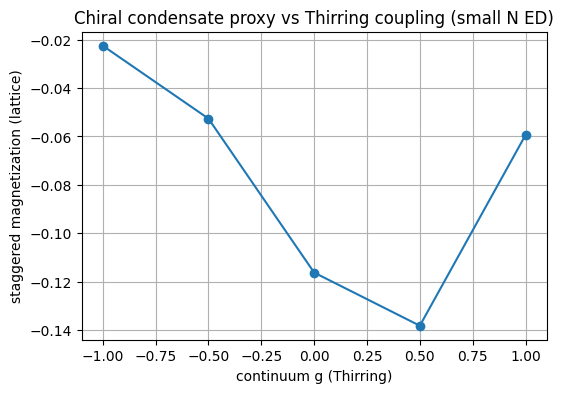

Sample string correlator Cx: {1: np.float64(-0.10262231878312937), 2: np.float64(0.059863406544566206), 3: np.float64(0.0006135175917756917), 4: np.float64(-0.015493815937115516), 5: np.float64(0.0062826327700517106), 6: np.float64(0.0024880909654544097)}


In [3]:
# lattice_thirring_xxz_ed.py
# Exact diagonalization demo: lattice Thirring -> XXZ spin chain (staggered field + anisotropy)
# Computes ground state, staggered magnetization, string correlator and low-energy spectrum.
#
# References for mapping and parameters: Banuls et al. (2019/2024) and lattice Thirring literature. :contentReference[oaicite:8]{index=8} :contentReference[oaicite:9]{index=9}

import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import itertools
import matplotlib.pyplot as plt

# ---------------------
# Utilities: spin-1/2 operators (sparse, 2x2)
# ---------------------
sx = sp.csr_matrix(np.array([[0., 1.],[1., 0.]], dtype=float))
sy = sp.csr_matrix(np.array([[0., -1j],[1j, 0.]], dtype=complex))
sz = sp.csr_matrix(np.array([[1., 0.],[0., -1.]], dtype=float))
sm = sp.csr_matrix(np.array([[0., 0.],[1., 0.]], dtype=float))  # S^- = |down><up|
sp_op = sp.csr_matrix(np.array([[0., 1.],[0., 0.]], dtype=float))  # raising? but we'll use sm, spare

I2 = sp.eye(2, dtype=complex, format='csr')

def kron_list(op_list):
    """Kronecker product of a list of sparse operators (left to right)"""
    res = op_list[0]
    for A in op_list[1:]:
        res = sp.kron(res, A, format='csr')
    return res

def local_op_on_chain(local_op, site, N):
    """Return many-body operator with local_op acting on 'site' (0-index)"""
    ops = [I2]*N
    ops[site] = local_op
    return kron_list(ops)

# ---------------------
# Parameter mapping (lattice -> spin chain)
# formulas from literature: gamma = (pi - g)/2 ; nu(gamma), Delta = cos(gamma) etc.
# See Banuls et al. and derivations. :contentReference[oaicite:10]{index=10} :contentReference[oaicite:11]{index=11}
# ---------------------
def gamma_from_g(g):
    return (np.pi - g) / 2.0

def nu_of_gamma(gamma):
    # ν(γ) = (2γ / π) / sin(γ)  (sometimes variations exist in literature)
    return (2.0 * gamma / np.pi) / np.sin(gamma + 1e-16)

def delta_of_gamma(gamma):
    return np.cos(gamma)

# ---------------------
# Build XXZ-like Hamiltonian (H̄sim in papers)
# Hbar = -1/2 sum (S+_n S-_n+1 + h.c.) + a mtilde0 sum (-1)^n (Sz_n + 1/2) + Delta sum (Sz_n + 1/2)(Sz_{n+1} + 1/2)
# We'll implement Sz as 1/2 sigma_z; but literature often uses Sz as sigma_z/2; be careful with prefactors.
# For simplicity implement Sz operator = sigma_z/2; S^+ = sigma^+/ (??). We'll match standard spin-1/2 conventions.
# ---------------------
def build_xxz_thirring(N, g_cont=0.5, m0a=0.1, a_lattice=1.0, open_boundary=True, penalty=0.0):
    """
    Build the many-body Hamiltonian (sparse) for N sites.
    g_cont: continuum Thirring coupling g (used to compute gamma etc.)
    m0a: dimensionless bare mass times lattice spacing
    a_lattice: lattice spacing (set to 1 by default)
    penalty: optional 'penalty' coefficient to fix total fermion number sector (not used by default)
    Returns H (sparse), and parameter dict for diagnostics.
    """
    g = g_cont
    gamma = gamma_from_g(g)
    nu = nu_of_gamma(gamma)
    Delta = delta_of_gamma(gamma)  # anisotropy parameter
    Zpsi = nu  # wavefunction renormalization factor mapping used in paper
    # effective prefactors: see Eqs in paper; implement Hbar as in references
    # Use Sz = sigma_z/2; S+ = sigma_+; S- = sigma_-
    Sz_local = 0.5 * sz
    Sp_local = sp.csr_matrix(np.array([[0., 1.],[0., 0.]], dtype=float))
    Sm_local = sp.csr_matrix(np.array([[0., 0.],[1., 0.]], dtype=float))

    # Precompute local many-body operators
    H = sp.csr_matrix((2**N, 2**N), dtype=complex)

    # H_hop = -1/2 sum (S+_n S-_n+1 + h.c.)
    for n in range(N-1 if open_boundary else N):
        # indices: n and n+1 (periodic would wrap)
        op_list = [I2]*N
        op_list[n]   = Sp_local
        op_list[n+1] = Sm_local
        term = kron_list(op_list)
        op_list[n]   = Sm_local
        op_list[n+1] = Sp_local
        term_hc = kron_list(op_list)
        H += (-0.5) * (term + term_hc)

    # staggered mass term: amtilde0 * sum_n (-1)^n (Sz_n + 1/2)
    amtilde0 = m0a  # following paper notation (m0a)
    for n in range(N):
        op = local_op_on_chain(Sz_local + 0.5*I2, n, N)
        H += (amtilde0 * ((-1)**n)) * op

    # anisotropy term: Delta * sum (Sz_n + 1/2)(Sz_{n+1} + 1/2)
    for n in range(N-1 if open_boundary else N):
        op_n   = local_op_on_chain(Sz_local + 0.5*I2, n, N)
        op_np1 = local_op_on_chain(Sz_local + 0.5*I2, n+1, N)
        H += Delta * (op_n.dot(op_np1))

    # optional penalty to fix fermion sector (in papers they add a penalty to force zero total fermion number)
    if penalty != 0.0:
        # total sz-like magnetization operator
        Sz_tot = sp.csr_matrix((2**N, 2**N), dtype=complex)
        for n in range(N):
            Sz_tot += local_op_on_chain(Sz_local, n, N)
        H += penalty * (Sz_tot.dot(Sz_tot))

    # scale H by prefactor if needed (paper defines H = nu(g)/a * Hbar). We'll return Hbar and the prefactors.
    return H.tocsr(), {'gamma': gamma, 'nu': nu, 'Delta': Delta, 'Zpsi': Zpsi, 'amtilde0': amtilde0}

# ---------------------
# Observables: staggered magnetization & string correlator
# ---------------------
def expectation_state(op, state_vec):
    # op sparse matrix, state_vec dense normalized vector
    v = state_vec
    return np.vdot(v, op.dot(v))

def compute_staggered_magnetization(N, psi_gs):
    Sz_local = 0.5 * sz
    mags = []
    for n in range(N):
        op = local_op_on_chain(Sz_local, n, N)
        mags.append(expectation_state(op, psi_gs).real)
    mags = np.array(mags)
    M_stag = np.mean([(-1)**n * mags[n] for n in range(N)])
    return M_stag, mags

def compute_string_correlator(N, state_vec, max_len=6):
    # average Cstring(x) over starting positions where x fits
    Sz_local = 0.5 * sz
    Cx = {}
    for x in range(1, max_len+1):
        vals = []
        for start in range(0, N - x):
            # build product Sz_start ... Sz_start+x
            prod = sp.eye(2**N, dtype=complex, format='csr')
            for k in range(start, start + x + 1):
                prod = prod.dot(local_op_on_chain(Sz_local, k, N))
            vals.append(expectation_state(prod, state_vec).real)
        Cx[x] = np.mean(vals) if len(vals)>0 else 0.0
    return Cx

# ---------------------
# Main small-run demonstration
# ---------------------
def run_demo(N=8, g=0.5, m0a=0.2, penalty=0.0, k_eigs=6):
    print(f"Running ED for N={N}, g={g}, m0a={m0a}")
    H, params = build_xxz_thirring(N, g_cont=g, m0a=m0a, penalty=penalty)
    print("Hamiltonian built. dim=", H.shape[0], " nnz=", H.nnz)
    # compute a few lowest eigenvalues (real symmetric? H is hermitian => eigsh ok)
    nev = min(k_eigs, H.shape[0]-2)
    # use eigsh for hermitian matrices; convert to real if small imaginary noise appears
    vals, vecs = spla.eigsh(H, k=nev, which='SA')  # smallest algebraic eigenvalues
    idx_sort = np.argsort(vals)
    vals = vals[idx_sort]
    vecs = vecs[:, idx_sort]
    gs_energy = vals[0].real
    print("Lowest energies:", vals.real)
    gs_vec = vecs[:,0]
    # normalize:
    gs_vec = gs_vec / np.linalg.norm(gs_vec)
    Mstag, local_mags = compute_staggered_magnetization(N, gs_vec)
    Cx = compute_string_correlator(N, gs_vec, max_len=min(6, N-1))
    return {'H': H, 'params': params, 'energies': vals.real, 'gs_vec': gs_vec, 'Mstag': Mstag, 'local_mags': local_mags, 'Cx': Cx}

# If run as script:
if __name__ == "__main__":
    # Example sweep over g to see behavior (small grid)
    Ns = [8]         # use N=8 for quick demo; increase to 10-12 if you have memory
    gs = [-1.0, -0.5, 0.0, 0.5, 1.0]   # sample Thirring couplings (continuum g)
    m0a = 0.1
    results = {}
    for N in Ns:
        results[N] = []
        for g in gs:
            res = run_demo(N=N, g=g, m0a=m0a, penalty=0.0, k_eigs=6)
            results[N].append((g, res))
            print(f"N={N} g={g:.3f}  GS energy={res['energies'][0]:.6f}  M_stag={res['Mstag']:.6e}  Cx={res['Cx']}")
        print("==== done N=", N)

    # Plot example: staggered magnetization vs g for N=8
    plt.figure(figsize=(6,4))
    gvals = [item[0] for item in results[8]]
    Mvals = [item[1]['Mstag'] for item in results[8]]
    plt.plot(gvals, Mvals, 'o-')
    plt.xlabel('continuum g (Thirring)')
    plt.ylabel('staggered magnetization (lattice)')
    plt.title('Chiral condensate proxy vs Thirring coupling (small N ED)')
    plt.grid(True)
    plt.show()

    # Print sample string correlator for last run
    last = results[8][-1][1]
    print("Sample string correlator Cx:", last['Cx'])
